Text(0, 0.5, 'MSE loss')

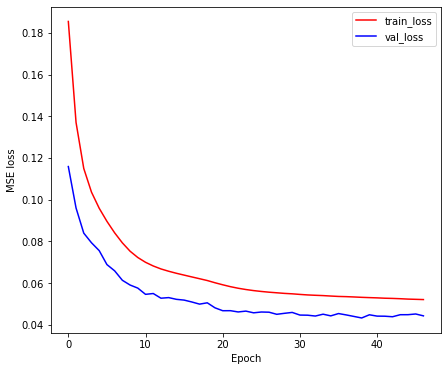

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
data = pd.read_csv("results/bigmodel_h512_l12_lr1e-5_metrics.csv")
val = data.dropna(subset = ['val_loss'])
train = data.dropna(subset = ['train_loss'])
epoch = train["epoch"]  
train_loss = train["train_loss"]
val_loss = val["val_loss"]
train_acc = train["train_acc"]
val_acc = val["val_acc"]

fig = plt.figure(figsize = (7,6)) 
p1 = pl.plot(epoch, train_loss,'r-', label = u'train_loss')
p2 = pl.plot(epoch,val_loss, 'b-', label = u'val_loss')
pl.legend()
pl.xlabel(u'Epoch')
pl.ylabel(u'MSE loss')

Text(0, 0.5, 'PCC')

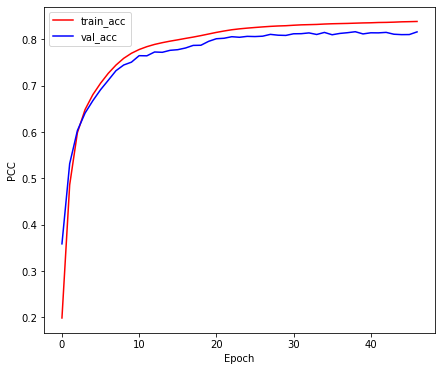

In [2]:
fig = plt.figure(figsize = (7,6)) 
p3 = pl.plot(epoch, train_acc,'r-', label = u'train_acc')
p4 = pl.plot(epoch,val_acc, 'b-', label = u'val_acc')
pl.legend()
pl.xlabel(u'Epoch')
pl.ylabel(u'PCC')

## De novo prediction

Initializing TransModel


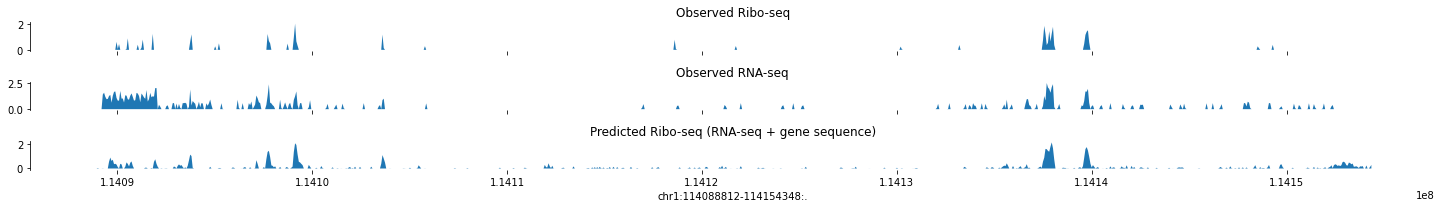

In [3]:
import kipoiseq
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from train_all_11fold import TrainModule, FastaStringExtractor

import matplotlib.pyplot as plt
import seaborn as sns

import pyBigWig
from kipoiseq import Interval
import math
import random

random.seed(2077)
SEQUENCE_LENGTH = 65536

def one_hot_encode(sequence):
    en_dict = {'A' : 0, 'T' : 1, 'C' : 2, 'G' : 3, 'N' : 4}
    en_seq = [en_dict[ch] for ch in sequence]
    np_seq = np.array(en_seq, dtype = int)
    seq_emb = np.zeros((len(np_seq), 5))
    seq_emb[np.arange(len(np_seq)), np_seq] = 1
    return seq_emb.astype(np.float32)

def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()
    
def get_cds_interval(gff_df, gene_name):
    # filter by gene_name
    gff_df = gff_df[gff_df[8].str.split(';').str[5].str.split('=').str[1] == gene_name]

    # generate dict
    gene_dict = {row[8].split(';')[0].split('=')[1]: {'chrom': row[0],'start': row[3], 'end': row[4], 'name':row[8].split(';')[7].split('=')[1], 
                                                      'cds_intervals': []} for _, row in gff_df.iterrows() if row[2] == 'transcript'}
    cds_df = gff_df[gff_df[2] == 'CDS']
    for _, row in cds_df.iterrows():
        gene_name = row[8].split(';')[3].split('=')[1]
        gene_dict[gene_name]['cds_intervals'].append((row[3], row[4]))
    target_gene = next((gene_info for gene_info in gene_dict.values()
                      ), None)
    if target_gene:
        cds_intervals = target_gene['cds_intervals']
        return {
            'chrom': target_gene['chrom'],
            'gene_start': target_gene['start'],
            'gene_end': target_gene['end'],
            'cds_intervals': cds_intervals,
            'gene_name': target_gene['name']
        }
    
def generate_inputs(region, fasta_file, bw_file, region_len=SEQUENCE_LENGTH):
    bw = pyBigWig.open(bw_file)
    target = []
    chrom = region.chrom
    start = region.start
    end = region.end
    chromosome_length = bw.chroms(chrom)
    interval = Interval(chrom, start, end).resize(region_len)
    trimmed_interval = Interval(interval.chrom,
                                max(interval.start, 0),
                                min(interval.end, chromosome_length),
                                )
    signals = np.array(bw.values(chrom, trimmed_interval.start, trimmed_interval.end)).astype(np.float32).tolist()
    pad_upstream = np.array([0] * max(-interval.start, 0)).astype(np.float32).tolist()
    pad_downstream = np.array([0] * max(interval.end - chromosome_length, 0)).astype(np.float32).tolist()
    tmp = pad_upstream + signals + pad_downstream
    arr = np.array(tmp).astype(np.float32)
    target.append(arr)

    target = np.array(target).astype(np.float32)
    target = np.nan_to_num(target,0)
    target = np.log(target + 1)
    bw.close()
    return target

def generate_outputs(region, fasta_file, bw_file, nBins=1024, region_len=65536):
    bw = pyBigWig.open(bw_file)
    target = []
    chrom = region.chrom
    start = region.start
    end = region.end
    chromosome_length = bw.chroms(chrom)
    interval = Interval(chrom, start, end).resize(region_len)
    trimmed_interval = Interval(interval.chrom,
                                max(interval.start, 0),
                                min(interval.end, chromosome_length),
                               )
    signals = np.array(bw.values(chrom, trimmed_interval.start, trimmed_interval.end)).astype(np.float32).tolist()
    pad_upstream = np.array([0] * max(-interval.start, 0)).astype(np.float32).tolist()
    pad_downstream = np.array([0] * max(interval.end - chromosome_length, 0)).astype(np.float32).tolist()
    tmp = pad_upstream + signals + pad_downstream
    arr = np.array(tmp).astype(np.float32)
    reshaped_arr = arr.reshape(-1, 64)
    averages = np.mean(reshaped_arr, axis=1)
    target.append(averages)

    target = np.array(target).astype(np.float32)
    target = np.nan_to_num(target,0)
    target = np.log(target + 1)
    bw.close()
    return target

device = 'cuda:0'
checkpoint = 'results/bigmodel_h512_l12_lr1e-5_epoch=38-step=746889.ckpt'
model = TrainModule.load_from_checkpoint(checkpoint).to(device)
model = model.eval()

fasta_file = 'data/hg38/hg38.fa'
fasta_extractor = FastaStringExtractor(fasta_file)
gff_file = 'data/hg38/gencode.v43.annotation.gff3'
rna_bw_file = 'data/hg38/K562/GSE153597/input_features/rnaseq.bw'
ribo_bw_file = 'data/hg38/K562/GSE153597/output_features/riboseq.bw'

gene_name = 'SYT6' #target gene

gff_df = pd.read_csv(gff_file, sep='\t', comment='#', header=None)
gene_info = get_cds_interval(gff_df, gene_name)

gene_interval =kipoiseq.Interval(gene_info['chrom'], gene_info['gene_start'], gene_info['gene_end'])
target_interval = Interval(gene_interval.chrom, gene_interval.start, gene_interval.end).resize(SEQUENCE_LENGTH)
ref_seq = fasta_extractor.extract(target_interval)
ref_emb = torch.Tensor(one_hot_encode(ref_seq)).to(device)

epi = torch.Tensor(generate_inputs(gene_interval, fasta_file, rna_bw_file)[0]).unsqueeze(1).to(device)
reference_input = torch.cat([ref_emb, epi], dim = 1).unsqueeze(0)
pred = model(reference_input)[0].detach().cpu().numpy()

gt = torch.Tensor(generate_outputs(gene_interval, fasta_file, ribo_bw_file)[0]).cpu().numpy()
rna = torch.Tensor(generate_outputs(gene_interval, fasta_file, rna_bw_file)[0]).cpu().numpy()

tracks = {'Observed Ribo-seq': gt,
          'Observed RNA-seq': rna,
          'Predicted Ribo-seq (RNA-seq + gene sequence)': pred
          }

plot_tracks(tracks, target_interval, height=1) 


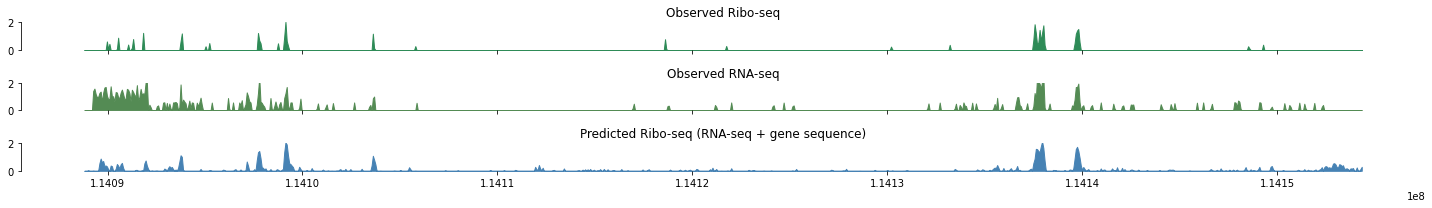

In [4]:
colors = {'Observed Ribo-seq': '#2E8B57',
          'Observed RNA-seq': '#548B54',
          'Predicted Ribo-seq (RNA-seq + gene sequence)': '#4682B4',
         }

def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    ylims = [(0, 2), (0, 2), (0, 2)]
    for ax, (title, y), ylim in zip(axes, tracks.items(),ylims):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y, color=colors[title])
        ax.set_title(title)
        ax.set_ylim(ylim)
        sns.despine(top=True, right=True, bottom=True)
    plt.tight_layout()

plot_tracks(tracks, target_interval, height=1)

## Contribution score

In [5]:
device = 'cuda:0'
checkpoint = 'results/bigmodel_h512_l12_lr1e-5_epoch=38-step=746889.ckpt'

model = TrainModule.load_from_checkpoint(checkpoint).to(device)
model = model.eval()

fasta_file = '/data/slurm/hejl/riboseq/data/hg38/hg38.fa'
fasta_extractor = FastaStringExtractor(fasta_file)
gff_file = '/data/slurm/hejl/riboseq/gencode.v43.annotation.gff3'
rna_bw_file = 'data/hg38/mean.sorted.bw' 

Initializing TransModel


Initializing TransModel


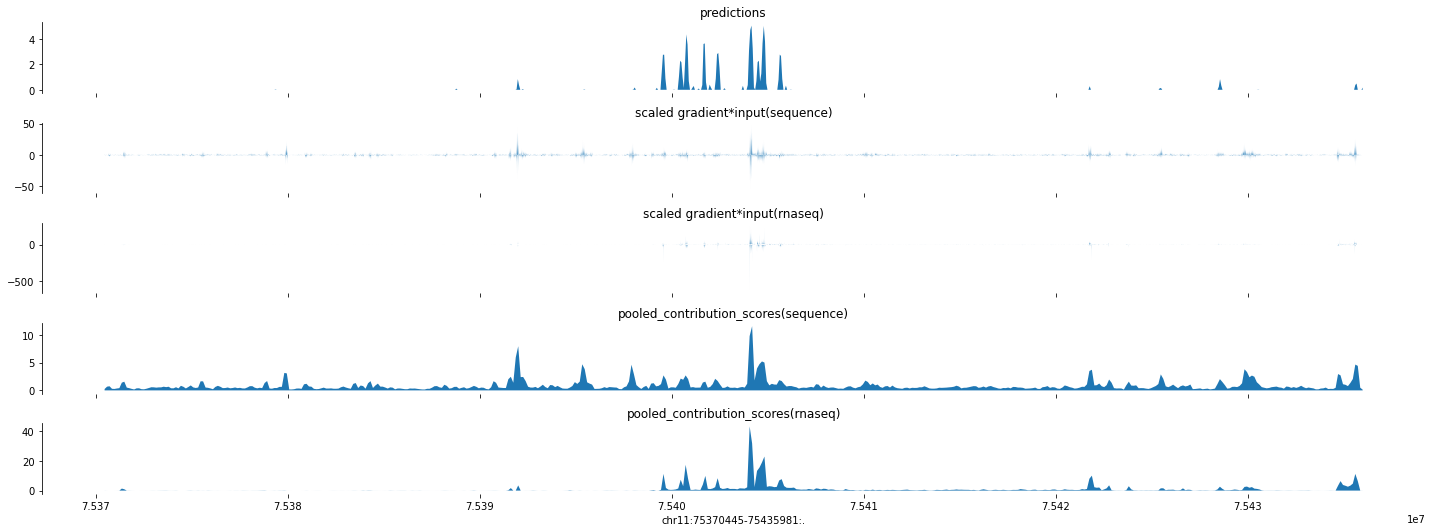

In [6]:
class model_x(nn.Module):
    def __init__(self, path, device):
        super().__init__()
        self.model = TrainModule.load_from_checkpoint(checkpoint).to(device).eval()
    def forward(self, x):
        reshaped_arr = torch.Tensor(x[:, :, 5:]).reshape(-1, 64)
        y = torch.mean(reshaped_arr, axis=1) + 1e-6
        return self.model(x)/y
    
model_x = model_x(checkpoint, device)

gene_interval =kipoiseq.Interval('chr11',75399518,75406907)  #RPS3-217 75399518,75406907
region_interval = gene_interval
target_interval = Interval(region_interval.chrom, region_interval.start, region_interval.end).resize(SEQUENCE_LENGTH)

ref_seq = fasta_extractor.extract(target_interval)

def one_hot_encode(sequence):
    en_dict = {'A' : 0, 'T' : 1, 'C' : 2, 'G' : 3, 'N' : 4}
    en_seq = [en_dict[ch] for ch in sequence]
    np_seq = np.array(en_seq, dtype = int)
    seq_emb = np.zeros((len(np_seq), 5))
    seq_emb[np.arange(len(np_seq)), np_seq] = 1
    return seq_emb.astype(np.float32)

def generate_inputs(interval, fasta_file, bw_file, region_len=SEQUENCE_LENGTH):
    bw = pyBigWig.open(bw_file)
    target = []
    chrom = interval.chrom
    start = interval.start
    end = interval.end
    chromosome_length = bw.chroms(chrom)
    trimmed_interval = Interval(interval.chrom,
                                max(interval.start, 0),
                                min(interval.end, chromosome_length),
                                )
    signals = np.array(bw.values(chrom, trimmed_interval.start, trimmed_interval.end)).astype(np.float32).tolist()
    pad_upstream = np.array([0] * max(-interval.start, 0)).astype(np.float32).tolist()
    pad_downstream = np.array([0] * max(interval.end - chromosome_length, 0)).astype(np.float32).tolist()
    tmp = pad_upstream + signals + pad_downstream
    arr = np.array(tmp).astype(np.float32)
    target.append(arr)

    target = np.array(target).astype(np.float32)
    target = np.nan_to_num(target,0)
    target = np.log(target + 1)
    bw.close()
    return target     

ref_emb = torch.Tensor(one_hot_encode(ref_seq)).to(device)
epi = torch.zeros(65536, 1).to(device)
model_input = torch.cat([ref_emb, epi], dim = 1).unsqueeze(0)
gt_epi = torch.Tensor(generate_inputs(target_interval, fasta_file, rna_bw_file)[0]).unsqueeze(1).to(device)
gt_model_input = torch.cat([ref_emb, gt_epi], dim = 1).unsqueeze(0)
target_mask = torch.ones_like(model(model_input)).to(device)

def scaled_contribution_input_grad(model, model_input, target_mask):
    model_input = model_input.clone().detach().requires_grad_(True)  # Clone and make it require gradients
    target_mask_mass = torch.sum(target_mask)
    # Forward pass
    prediction = torch.sum(target_mask * model(model_input)) / target_mask_mass
    # Backward pass
    prediction.backward()
    input_grad = model_input.grad * model_input
    input_grad = input_grad[:, :, :5]
    input_grad = input_grad.squeeze(0)
    return input_grad.sum(axis=-1).detach()

def scaled_contribution_input_grad_rnaseq(model, model_input, target_mask):
    model_input = model_input.clone().detach().requires_grad_(True)
    target_mask_mass = torch.sum(target_mask)
    # Forward pass
    prediction = torch.sum(target_mask * model(model_input)) / target_mask_mass
    # Backward pass
    prediction.backward()
    input_grad = model_input.grad * model_input
    input_grad = input_grad[:, :, 5:]
    input_grad = input_grad.squeeze(0)
    return input_grad.sum(axis=-1).detach()

scaled_contribution_scores = scaled_contribution_input_grad(model_x, gt_model_input, torch.Tensor(target_mask))
scaled_contribution_scores_rnaseq = scaled_contribution_input_grad_rnaseq(model_x, gt_model_input, torch.Tensor(target_mask))

prediction = model(model_input)[0].detach().cpu().numpy()
gt_prediction = model(gt_model_input)[0].detach().cpu().numpy()

def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()

pooled_contribution_scores = F.avg_pool1d(torch.abs(scaled_contribution_scores).unsqueeze(0), 128, 128)[0].detach().cpu().numpy()
pooled_contribution_scores_rnaseq = F.avg_pool1d(torch.abs(scaled_contribution_scores_rnaseq).unsqueeze(0), 128, 128)[0].detach().cpu().numpy()

tracks = {
          'predictions':  gt_prediction[:], #2 inputs
          'scaled gradient*input(sequence)':scaled_contribution_scores.detach().cpu().numpy(),
          'scaled gradient*input(rnaseq)':scaled_contribution_scores_rnaseq.detach().cpu().numpy(),
    'pooled_contribution_scores(sequence)': pooled_contribution_scores,
          'pooled_contribution_scores(rnaseq)': pooled_contribution_scores_rnaseq}

plot_tracks(tracks, target_interval)

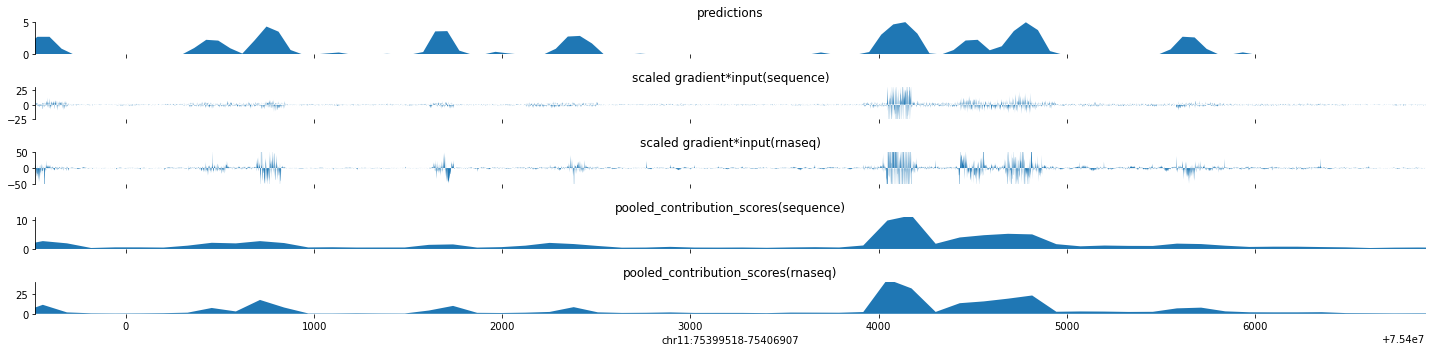

In [7]:
def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    ylims = [(0,5), (-25, 30),(-50, 50),(0,11),(0, 40)]
    for ax, (title, y), ylim in zip(axes, tracks.items(), ylims):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        #ax.set_ylim(0, 3)
        ax.set_ylim(ylim)
        ax.set_xlim(75399518, 75406907)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel("chr11:75399518-75406907")
    plt.tight_layout()
plot_tracks(tracks, target_interval, height=1)

## In silico mutation

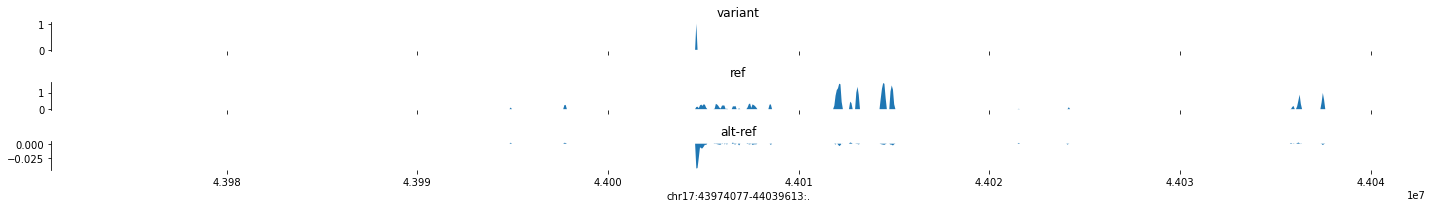

In [8]:
def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()

def one_hot_encode(sequence):
    en_dict = {'A' : 0, 'T' : 1, 'C' : 2, 'G' : 3, 'N' : 4}
    en_seq = [en_dict[ch] for ch in sequence]
    np_seq = np.array(en_seq, dtype = int)
    seq_emb = np.zeros((len(np_seq), 5))
    seq_emb[np.arange(len(np_seq)), np_seq] = 1
    return seq_emb.astype(np.float32)

def variant_generator(vcf_file):
    with open(vcf_file) as f:
        for line in f:
            chrom, pos, id, ref, alt = line.split('\t')[:5]
            
      # Split ALT alleles and return individual variants as output.
            yield kipoiseq.Variant(chrom=chrom, pos=pos,ref=ref, alt=alt, id=id)
        
def get_cds_interval(gff_df, snp_chrom, snp_position):
    # filter by chromosome
    gff_df = gff_df[gff_df[0] == snp_chrom]

    # generate dict
    gene_dict = {row[8].split(';')[0].split('=')[1]: {'start': row[3], 'end': row[4], 'name':row[8].split(';')[7].split('=')[1], 
                                                      'cds_intervals': []} for _, row in gff_df.iterrows() if row[2] == 'transcript'}
    cds_df = gff_df[gff_df[2] == 'CDS']
    for _, row in cds_df.iterrows():
        gene_name = row[8].split(';')[3].split('=')[1]
        gene_dict[gene_name]['cds_intervals'].append((row[3], row[4]))
    target_gene = next((gene_info for gene_info in gene_dict.values()
                       if gene_info['start'] <= snp_position <= gene_info['end']), None)
    if target_gene:
        cds_intervals = target_gene['cds_intervals']
        return {
            'gene_start': target_gene['start'],
            'gene_end': target_gene['end'],
            'cds_intervals': cds_intervals,
            'gene_name': target_gene['name']
        }

def get_start_codon_interval(gff_df, snp_chrom, snp_position):
    # filter by chromosome
    gff_df = gff_df[gff_df[0] == snp_chrom]

    # generate dict
    gene_dict = {row[8].split(';')[0].split('=')[1]: {'start': row[3], 'end': row[4], 'name':row[8].split(';')[7].split('=')[1], 
                                                      'start_codon_intervals': []} for _, row in gff_df.iterrows() if row[2] == 'transcript'}
    start_codon_df = gff_df[gff_df[2] == 'start_codon']
    for _, row in start_codon_df.iterrows():
        gene_name = row[8].split(';')[3].split('=')[1]
        gene_dict[gene_name]['start_codon_intervals'].append((row[3], row[4]))
    target_gene = next((gene_info for gene_info in gene_dict.values()
                       if gene_info['start'] <= snp_position <= gene_info['end']), None)
    if target_gene:
        start_codon_intervals = target_gene['start_codon_intervals']
        return {
            'gene_start': target_gene['start'],
            'gene_end': target_gene['end'],
            'start_codon_intervals': start_codon_intervals,
            'gene_name': target_gene['name']
        }
              
def generate_inputs(interval, fasta_file, bw_file, region_len=SEQUENCE_LENGTH):
    bw = pyBigWig.open(bw_file)
    target = []
    chrom = interval.chrom
    start = interval.start
    end = interval.end
    chromosome_length = bw.chroms(chrom)
    trimmed_interval = Interval(interval.chrom,
                                max(interval.start, 0),
                                min(interval.end, chromosome_length),
                                )
    signals = np.array(bw.values(chrom, trimmed_interval.start, trimmed_interval.end)).astype(np.float32).tolist()
    pad_upstream = np.array([0] * max(-interval.start, 0)).astype(np.float32).tolist()
    pad_downstream = np.array([0] * max(interval.end - chromosome_length, 0)).astype(np.float32).tolist()
    tmp = pad_upstream + signals + pad_downstream
    arr = np.array(tmp).astype(np.float32)
    target.append(arr)

    target = np.array(target).astype(np.float32)
    target = np.nan_to_num(target,0)
    target = np.log(target + 1)
    bw.close()
    return target

variant = kipoiseq.Variant(chrom = 'chr17', pos = 44004661, ref = 'G', alt= 'T')
gff_df = pd.read_csv(gff_file, sep='\t', comment='#', header=None)
gene_info = get_start_codon_interval(gff_df, variant.chrom, variant.start)

gene_interval =kipoiseq.Interval(variant.chrom, gene_info['gene_start'], gene_info['gene_end'])
region_interval = gene_interval.resize(SEQUENCE_LENGTH)
ref_seq = fasta_extractor.extract(region_interval)
tmp_seq = ref_seq
alt_loc = variant.pos - region_interval.start -1
if ref_seq[alt_loc] == variant.ref:
    alt_seq = ref_seq[:alt_loc] + variant.alt + ref_seq[alt_loc+1:]
    ref_emb = torch.Tensor(one_hot_encode(ref_seq)).to(device)
    alt_emb = torch.Tensor(one_hot_encode(alt_seq)).to(device)
    epi = torch.Tensor(generate_inputs(region_interval, fasta_file, rna_bw_file)[0]).unsqueeze(1).to(device)
    reference_input = torch.cat([ref_emb, epi], dim = 1).unsqueeze(0)
    alternate_input = torch.cat([alt_emb, epi], dim = 1).unsqueeze(0)

    reference_prediction = model(reference_input)[0].detach().cpu().numpy()
    alternate_prediction = model(alternate_input)[0].detach().cpu().numpy()
    
    variant_scores = alternate_prediction - reference_prediction
    
    cds_values = []
    cds_ref = []
    cds_alt = []
    # extract values in CDS intervals
    for cds_interval in gene_info['start_codon_intervals']:
        istart = int(math.floor((cds_interval[0]- region_interval.start)/64))
        iend = int(math.ceil((cds_interval[1]- region_interval.start)/64))
        values = np.array(variant_scores[istart:iend], dtype = np.float32)
        ref_v = np.array(reference_prediction[istart:iend], dtype = np.float32)
        alt_v = np.array(alternate_prediction[istart:iend], dtype = np.float32)
        cds_values.extend(values)
        cds_ref.extend(ref_v)
        cds_alt.extend(alt_v)
    variant_sum = np.sum(np.array(cds_values), dtype = np.float32)
    ref_sum = np.sum(np.array(cds_ref), dtype = np.float32)
    alt_sum = np.sum(np.array(cds_alt), dtype = np.float32)
    
    variant_track = np.zeros_like(reference_prediction[:], dtype=bool)
    variant_track[int(math.floor((variant.pos- region_interval.start)/64))] = True

tracks = {'variant': variant_track,
          'ref': reference_prediction[:],
          'alt-ref': alternate_prediction[:] - reference_prediction[:]
          }

plot_tracks(tracks, region_interval, height=1)

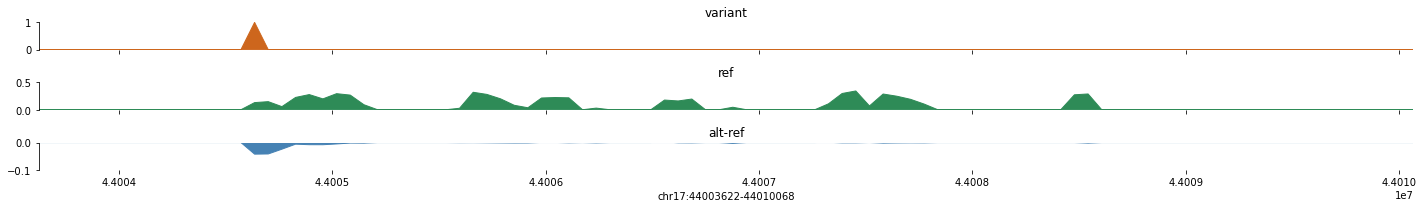

In [9]:
colors = {'variant':  '#CD661D',
          'ref': '#2E8B57',
          'alt-ref': '#4682B4'}

def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    ylims = [(0, 1), (0, 0.5),(-0.1,0)]
    for ax, (title, y), ylim in zip(axes, tracks.items(), ylims):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y, color=colors[title])
        ax.set_title(title)
        ax.set_ylim(ylim)
        ax.set_xlim(44003622, 44010068)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel("chr17:44003622-44010068")
    plt.tight_layout()

plot_tracks(tracks, region_interval, height=1)